## Advanced Path Finding with PYORPS

This notebook demonstrates advanced path finding capabilities using PYORPS with parallel path computation, multiple
input datasets and custom cost modifications.
It shows how to find efficient routes while considering environmental constraints like water protection zones,
nature reserves, and protected landscapes.

### Data Preparation

The data required for this example cannot be provided directly due to copyright reasons.
However, they can be obtained from the original sources:

- [Natura 2000](https://www.eea.europa.eu/data-and-maps/data/natura-14/natura-2000-spatial-data)
- [Water protection areas](https://www.hlnug.de/themen/geografische-informationssysteme/geodienste/wasser)
- [Protected Landscape](https://natureg.hessen.de/infomaterial/geodaten.php)

Download these datasets and place them in the project directory `./data/shapes/additional_data`.


### 1. Importing the PathFinder Module

First, we import the `PathFinder` module from PYORPS, which provides comprehensive functionality for
path finding and visualization.

In [1]:
from pyorps import PathFinder

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNameError: name '_calculate_source_region_bounds' is not defined[0m
[0m[1mDuring: Pass nopython_type_inference[0m

### 2. Define Base Dataset Source

We use a WFS (Web Feature Service) as our base dataset. This provides land cover data
that will be rasterized and used as the foundation for our path finding.

In [2]:
# WFS-Request for base file
base_file_url = "https://www.gds.hessen.de/wfs2/aaa-suite/cgi-bin/alkis/vereinf/wfs"
base_file = {
    "url": base_file_url,
    "layer": "ave_Nutzung",
}

### 3. Define Cost Modifications

We need to specify how various protected areas should affect routing costs:
- For water protection zones, we use a nested dictionary to assign different costs based on zone type
- For other protected areas, we either use fixed costs or multipliers to adjust the base costs

#### 3.1 Buffer Settings and Water Protection Zone Costs

First, we define a buffer distance for all geometries and detailed cost assumptions
for water protection zones.

In [3]:
# Set geometry buffer in m which will be applied to all geometries
geometry_buffer_m = 20

# Define a nested dictionary for specific cost assumptions for the water protection zones
water_protection_cost_assumptions = {
    "ZONE": {
        'Schutzzone I': 65535,             # Innermost protection zone (effectively forbidden)
        'Schutzzone II': 5000,             # High protection zone
        'Qualitative Schutzzone I': 65535, # Qualitative protection zone I (effectively forbidden)
        'Qualitative Schutzzone II': 5000, # Qualitative protection zone II
        'Quantitative Schutzzone A': 65535,# Quantitative protection zone A (effectively forbidden)
        'Quantitative Schutzzone B': 2000, # Quantitative protection zone B
        '': 1200                           # Default value for unspecified zones
    }
}


#### 3.2 Additional Datasets for Cost Modification

Now we define all additional datasets that will modify our base cost raster.
Each dataset entry specifies:
- Input file path
- Cost assumptions (fixed value, multiplier, or dictionary)
- Buffer distance
- Whether to multiply or replace costs

Note: Additional Datasets will be transformed in the CRS of the base dataset - no adjustments needed!

In [4]:
# Create a list with dictionaries for the datasets which should be used to modify the base data
datasets_to_modify = [
    {
        "input_data": "./data/shapes/additional_data/Natura2000_end2021_rev1.gpkg",
        "cost_assumptions": 1200,
        "geometry_buffer_m": geometry_buffer_m,
        "layer": "NaturaSite_polygon"
    },
    {
        "input_data": "./data/shapes/additional_data/LSG_Hessen_UTM.shp",
        "cost_assumptions": 1.1,
        "geometry_buffer_m": geometry_buffer_m,
        "multiply": True
    },
    {
        "input_data": "./data/shapes/additional_data/TWS_HQS_TK25.shp",
        "cost_assumptions": water_protection_cost_assumptions,
        "geometry_buffer_m": geometry_buffer_m,
    },
]

### 4. Define the Search Area and Coordinates

We'll restrict our analysis to a specific area defined by a bounding box, and set up our source and target
coordinates within this area. It is crucial that this bounding box is in the same Coordinate Reference System (CRS)
as the base dataset, as this ensures accurate data retrieval and alignment ("EPSG:25832" in this case).

In [5]:
# Define a tuple to restrict the area and therefore the amount of data to be used.
box_tuple = (471228, 5592632, 474176, 5594879)

#### 4.1 Define Source and Target Coordinates

We'll start with a single source point and two target points to demonstrate
parallel path finding to multiple destinations.

In [6]:
delta = 200
source_coords = (box_tuple[0] + delta, box_tuple[1] + delta)
target_coords = [(box_tuple[2] - delta, box_tuple[3] - delta),
                 (box_tuple[2] - delta, box_tuple[3] - 10 * delta)]

### 5. Initialize the PathFinder

Now we create the PathFinder instance with all our parameters. This will:
1. Download the WFS data within our bounding box
2. Apply the base cost assumptions
3. Modify the costs with our additional datasets
4. Create a search space with a 1km buffer around our points

Note: If you are using `GeoPandas` Version < 1.1, you will receive an unwarranted UserWarning which can be ignored!

In [16]:
# Set the path to the cost assumptions for the base file
cost_file_path_for_base_file = r"./data/cost_assumptions/cost_assumptions.csv"

path_finder = PathFinder(
    dataset_source=base_file,
    source_coords=source_coords,
    target_coords=target_coords,
    search_space_buffer_m=1000,
    cost_assumptions=cost_file_path_for_base_file,
    bbox=box_tuple,
    datasets_to_modify=datasets_to_modify,
    geometry_buffer_m=geometry_buffer_m
)

C:\Users\mhnn82\Documents\3_python_projects\pyorps\.venv\Lib\site-packages\geopandas\io\file.py:484: UserWarning: More than one layer found in 'Natura2000_end2021_rev1.gpkg': 'NaturaSite_polygon' (default), 'BIOREGION', 'DESIGNATIONSTATUS', 'DIRECTIVESPECIES', 'HABITATS', 'HABITATCLASS', 'NATURA2000SITES', 'OTHERSPECIES', 'METADATA', 'IMPACT', 'MANAGEMENT', 'SPECIES'. Specify layer parameter to avoid this warning.
  crs = pyogrio.read_info(path_or_bytes).get("crs")


### 6. Parallel Path Finding: One Source to Multiple Targets

Let's calculate paths from one source to multiple targets.

#### Runtime Note:
When calculating paths to multiple targets from a single source, PYORPS processes them in parallel,
which is usually more efficient than sequential calculations. If the source-target combinations result in a bigger
graph, sequential calculations may be more efficient. The Dijkstra algorithm is run once from the source, and paths
to all targets are extracted from the resulting distance matrix.

**Base runtime** for 2 targets and graph creation included

In [8]:
# Start the path finding process by calling the find_route method without any inputs
# This will use the source and target coordinates provided during initialization
route_result = path_finder.find_route()

Display the results, including path lengths and costs

In [9]:
# Show the summary of the resulting paths
print(route_result)

PathCollection(count=2)


### 7. Visualize the Routes

The `PathFinder` class provides a convenient method to visualize the calculated paths.
Here we create separate plots for each path with custom titles.

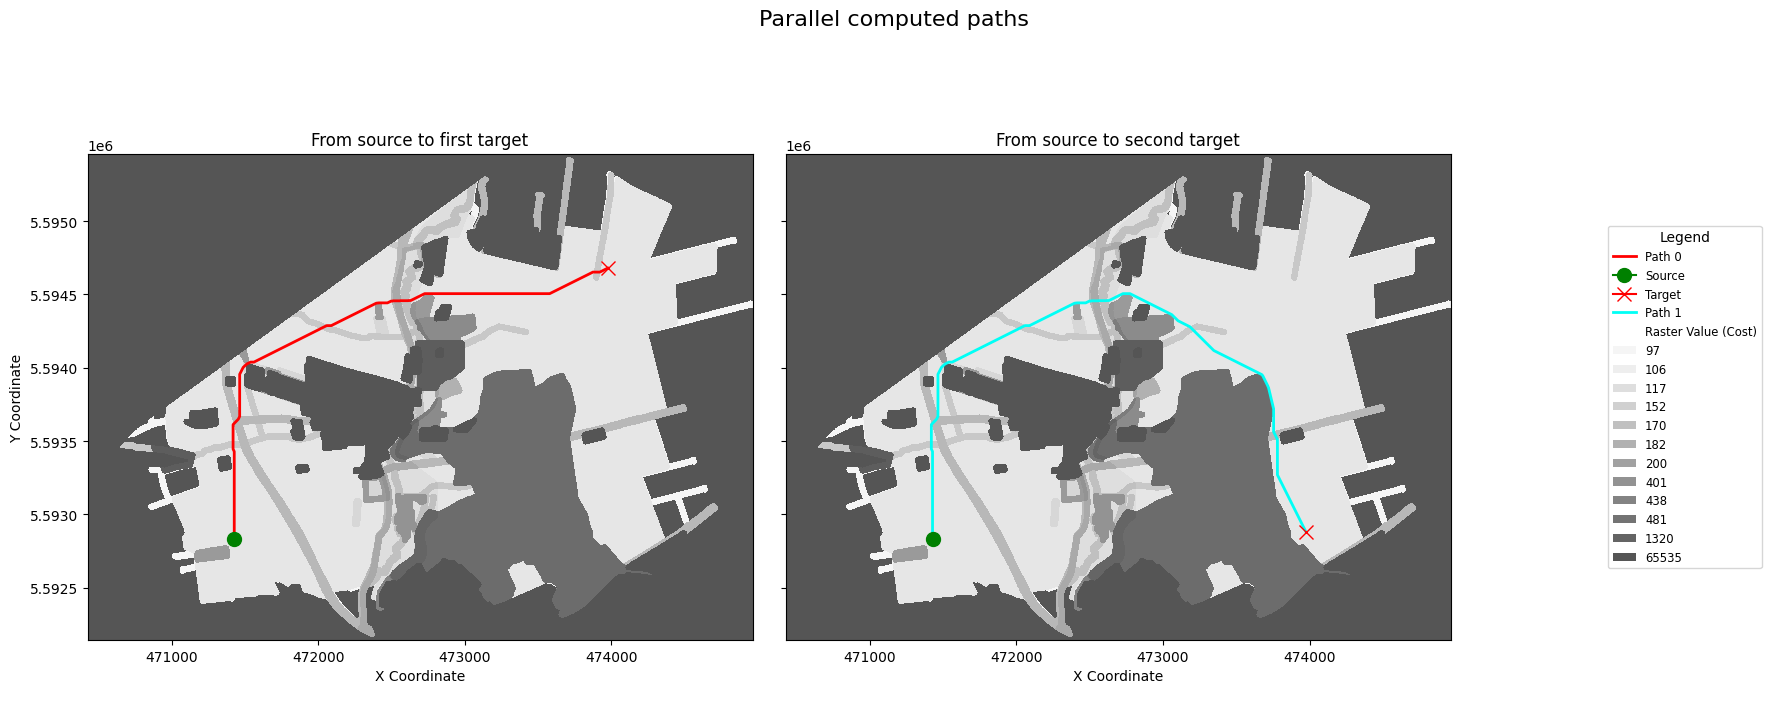

[<Axes: title={'center': 'From source to first target'}, xlabel='X Coordinate', ylabel='Y Coordinate'>,
 <Axes: title={'center': 'From source to second target'}, xlabel='X Coordinate'>]

In [10]:
# Plot the paths and set appropriate titles for the subplots and a suptitle for the figure
path_finder.plot_paths(title=['From source to first target', 'From source to second target'],
                       sup_title="Parallel computed paths")

### 8. Advanced Path Finding: Multiple Sources to Multiple Targets (All Combinations)

Now we'll define new source coordinates and calculate paths from all sources to all targets.

#### Runtime Note:
With `pairwise=False`, PYORPS calculates paths between all combinations of sources and targets.
If you have S sources and T targets, this means S×T paths will be calculated. 


**Typical runtime:** ~66 % of base runtime for four paths (without graph creation - the previously created graph will
 be used)

In [11]:
# Provide other source coords to the find_route method and set pairwise to False. 
# This calculates all 4 possible paths from 2 sources to 2 targets in parallel
source_coords = [(472900, 5593200), (472200, 5594500)]
new_source_paths_pairwise_false = path_finder.find_route(source=source_coords, pairwise=False)

Plot the results showing all four combinations of paths

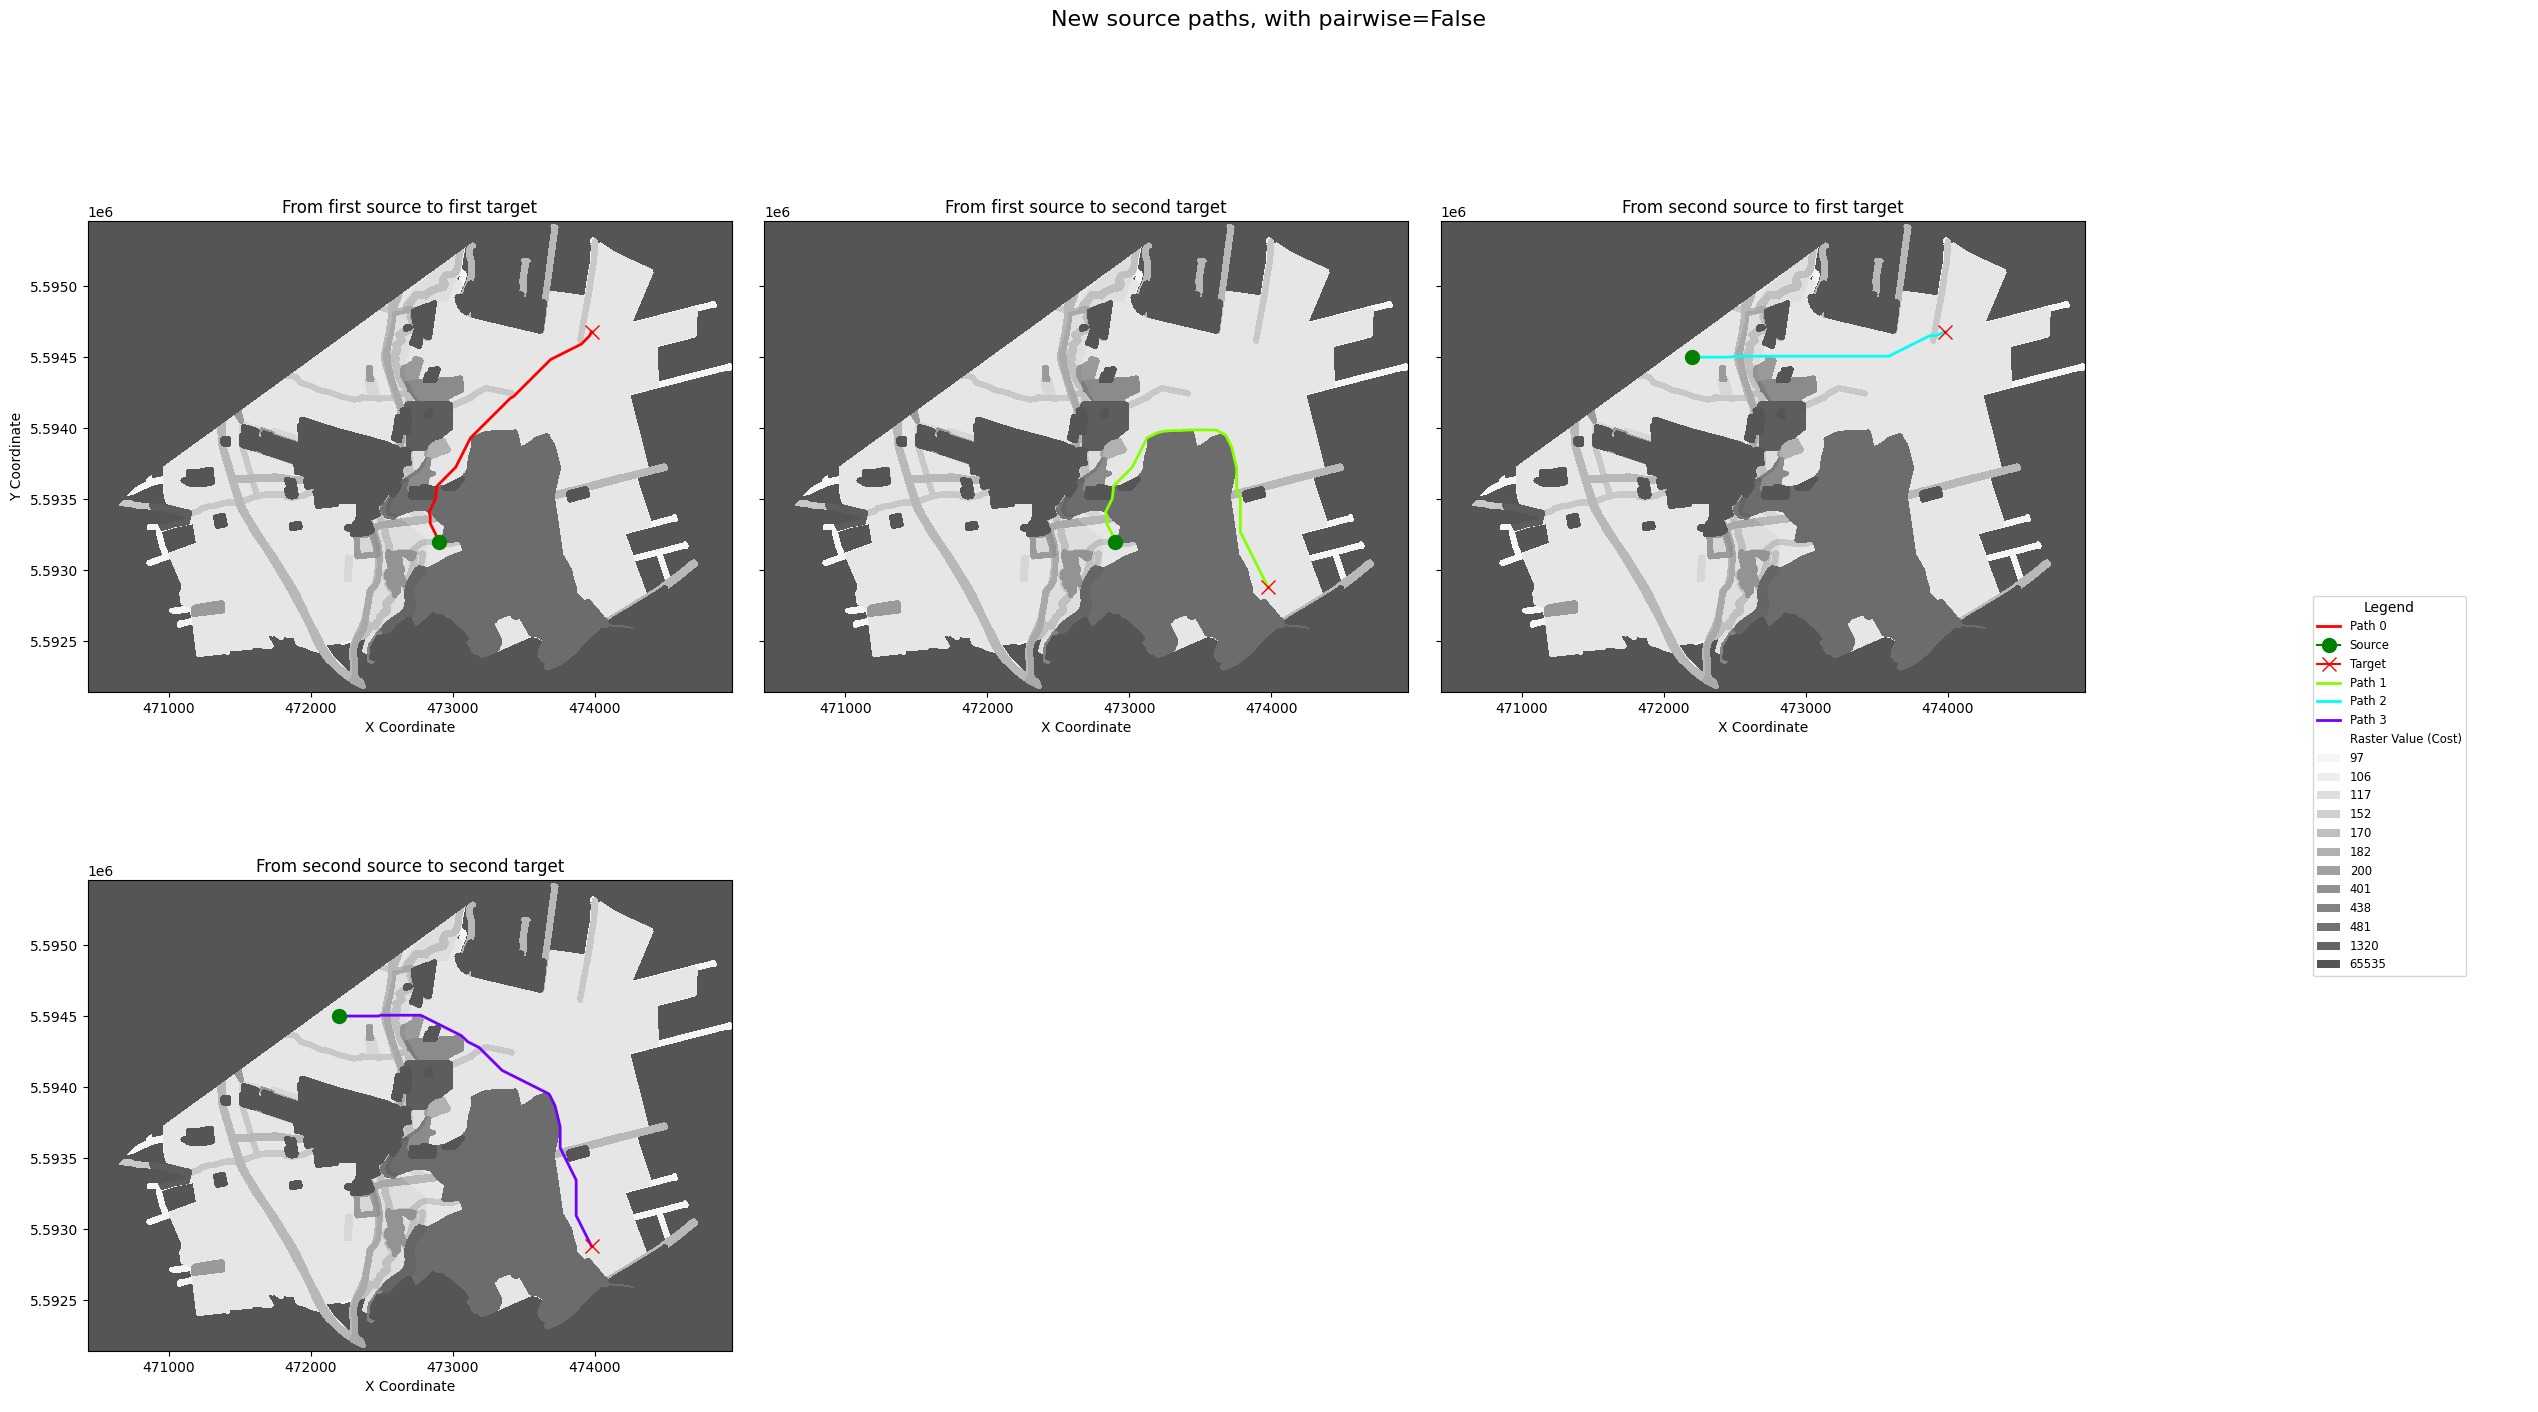

[<Axes: title={'center': 'From first source to first target'}, xlabel='X Coordinate', ylabel='Y Coordinate'>,
 <Axes: title={'center': 'From first source to second target'}, xlabel='X Coordinate'>,
 <Axes: title={'center': 'From second source to first target'}, xlabel='X Coordinate'>,
 <Axes: title={'center': 'From second source to second target'}, xlabel='X Coordinate'>]

In [12]:
# Plot the results for pairwise=False
path_finder.plot_paths(paths=new_source_paths_pairwise_false, sup_title="New source paths, with pairwise=False",
                       title=['From first source to first target',
                               'From first source to second target',
                               'From second source to first target',
                               'From second source to second target'])

### 9. Pairwise Path Finding: Matched Source-Target Pairs

Sometimes we want to calculate paths only between specific source-target pairs.
With `pairwise=True`, PYORPS matches sources and targets by index position.

#### Runtime Note:
Pairwise routing is most efficient when you have specific source-target pairs. This is faster than the all-combinations approach when you only need
specific pairings.

**Typical runtime:** ~50 % of base runtime for two paths (without graph creation - the previously created graph will
 be used)

In [13]:
# Use the same source and target coordinates as before, but set pairwise=True. 
# This will calculate only two paths: first source to first target, and second source to second target
new_source_paths_pairwise_true = path_finder.find_route(source=source_coords, pairwise=True)

Plot the results showing only the two matched source-target paths

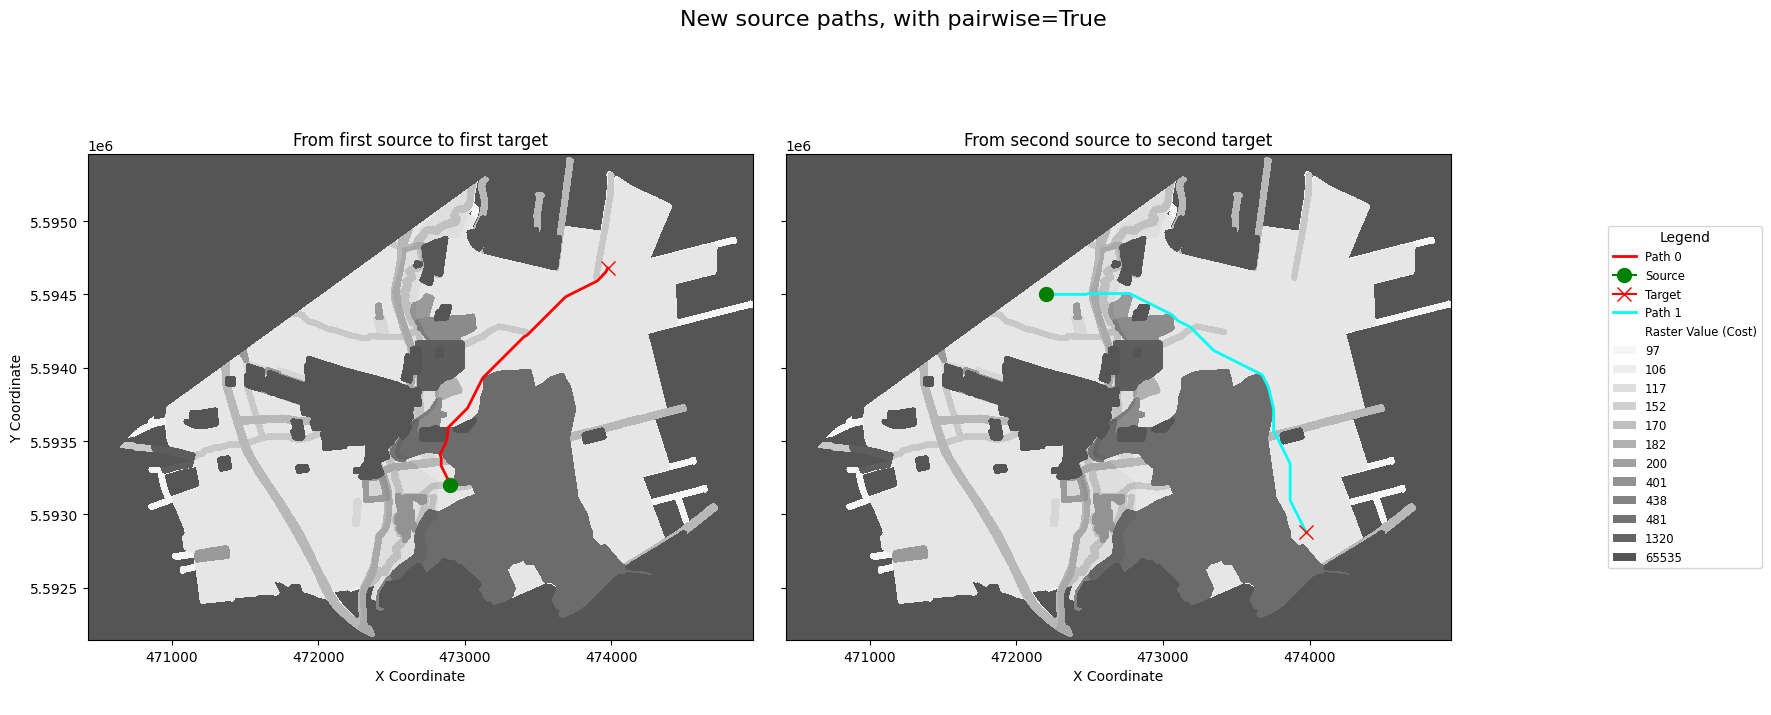

[<Axes: title={'center': 'From first source to first target'}, xlabel='X Coordinate', ylabel='Y Coordinate'>,
 <Axes: title={'center': 'From second source to second target'}, xlabel='X Coordinate'>]

In [14]:
path_finder.plot_paths(paths=new_source_paths_pairwise_true, sup_title="New source paths, with pairwise=True",
                       title=['From first source to first target',
                               'From second source to second target'])